In [1]:
import pandas as pd
import numpy as np
import pyspark
from pyspark.sql import SQLContext
from pyspark.ml.feature import CountVectorizer , IDF
from nltk.corpus import stopwords
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.sql import SparkSession
from pyspark.ml.feature import StopWordsRemover
import re
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
import time
# from pyspark.sql.functions import lower, col

In [2]:
spark = SparkSession.builder \
            .appName("Topic Modeling")\
            .config("spark.driver.extraClassPath")\
            .getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('WARN')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/09 10:54:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/09 10:54:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
data = spark.read.csv('data.csv', header = True)

In [5]:
data.tail(20)

[Row(clean_text1='What The 2016 OscarNominated Films Can Teach Us About Trauma And Addiction'),
 Row(clean_text1='Caeleb Dressel Swims With His Dog Jane In Gold MedalWorthy Video'),
 Row(clean_text1='Football Fans Lose Faith In Humanity As Patriots Head To Another Super Bowl'),
 Row(clean_text1='Aaron Hernandez Had Most Severe CTE Ever Found For Someone His Age Researchers Say'),
 Row(clean_text1='Heres How  And Why  The Falcons Could Win The Super Bowl'),
 Row(clean_text1='Cleveland Weatherman Wont Shave Gnarly Beard Until The Browns Win'),
 Row(clean_text1='Here Are All The Ways To Stream The 2016 Rio Olympics Online'),
 Row(clean_text1='Secrets Of A Professional Present Purchaser'),
 Row(clean_text1='The Throwback Fashion Trend Youll See Everywhere In 2018'),
 Row(clean_text1='The 25 Best Womens Fashion Deals Of The Nordstrom Anniversary Sale Under 100'),
 Row(clean_text1='Kate Middleton Is Rocking A Hairdo In Time For A Summer Trip'),
 Row(clean_text1='We Bet You Cant Tell The Diff

In [6]:
stop_words = stopwords.words("english")

In [7]:
lower_tokens = data.select(F.lower(F.col('clean_text1')).alias('clean_text1'))

In [8]:
lower_tokens = lower_tokens.withColumn('words',F.split(F.col('clean_text1'),' '))

In [9]:
remover = StopWordsRemover(inputCol="words", \
                   outputCol="words_no_sw").setStopWords(stop_words)

remover_pipeline = Pipeline(stages=[remover])
pipelineFitRemoveStopWords = remover_pipeline.fit(lower_tokens)

In [10]:
tokens = pipelineFitRemoveStopWords.transform(lower_tokens)

In [11]:
tokens = tokens.select(F.monotonically_increasing_id().alias('id'), 'words_no_sw')
tokens.show()

+---+--------------------+
| id|         words_no_sw|
+---+--------------------+
|  0|[elephant, attack...|
|  1|[national, elepha...|
|  2|[animal, photos, ...|
|  3|[hurricane, sandy...|
|  4|[reusable, replac...|
|  5|[easter, 2012, pe...|
|  6|[hatch, watch, 20...|
|  7|[concussions, sho...|
|  8|[14, quote, cards...|
|  9|[glen, campbells,...|
| 10|[mallinckrodt, se...|
| 11|[patients, helped...|
| 12|[6, proven, strat...|
| 13|[lindsey, vonn, t...|
| 14|[french, skier, b...|
| 15|[sport, society, ...|
| 16|[8, brands, turn,...|
| 17|[demi, lovato, pr...|
| 18|[drew, barrymores...|
| 19|[halima, aden, al...|
+---+--------------------+
only showing top 20 rows



In [12]:
cv = CountVectorizer(inputCol="words_no_sw", outputCol="raw_features", vocabSize=5000, minDF=10.0)
cvmodel = cv.fit(tokens)

result_cv = cvmodel.transform(tokens)

In [13]:
idf = IDF(inputCol="raw_features", outputCol="features")#, dtype = float32)
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv)

In [14]:
result_tfidf.show()

+---+--------------------+--------------------+--------------------+
| id|         words_no_sw|        raw_features|            features|
+---+--------------------+--------------------+--------------------+
|  0|[elephant, attack...|(1094,[236,537,78...|(1094,[236,537,78...|
|  1|[national, elepha...|(1094,[55,153,187...|(1094,[55,153,187...|
|  2|[animal, photos, ...|(1094,[3,16,36,14...|(1094,[3,16,36,14...|
|  3|[hurricane, sandy...|(1094,[0,15,53,15...|(1094,[0,15,53,15...|
|  4|[reusable, replac...|        (1094,[],[])|        (1094,[],[])|
|  5|[easter, 2012, pe...|(1094,[142,265,69...|(1094,[142,265,69...|
|  6|[hatch, watch, 20...|(1094,[56,142,579...|(1094,[56,142,579...|
|  7|[concussions, sho...|(1094,[0,443,562]...|(1094,[0,443,562]...|
|  8|[14, quote, cards...|(1094,[7,399],[1....|(1094,[7,399],[3....|
|  9|[glen, campbells,...|(1094,[26,101,578...|(1094,[26,101,578...|
| 10|[mallinckrodt, se...|(1094,[0,61,136,2...|(1094,[0,61,136,2...|
| 11|[patients, helped...|(1094,[2

In [15]:
features = result_tfidf[['features']]

In [16]:
vocabulary = cvmodel.vocabulary
features_np = np.array(features)

In [17]:
print(features_np)

DataFrame[features: vector]


In [18]:
df_txts = result_tfidf.select('id','words_no_sw')

In [19]:
cv = CountVectorizer(inputCol="words_no_sw", outputCol="raw_features", vocabSize=5000, minDF=10.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)

In [20]:
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv)

In [21]:
num_topics = 5
max_iterations = 50

start_time = time.time()
model=LDA.train(
  result_tfidf.select("id", "features").rdd.mapValues(Vectors.fromML).map(list),k=num_topics,maxIterations=max_iterations
)


In [22]:
vocabArray = cvmodel.vocabulary

In [23]:
wordNumbers = 10
topicIndices = sc.parallelize(model.describeTopics\
                              (maxTermsPerTopic = wordNumbers))
def topic_render(topic):  # specify vector id of words to actual words
    terms = topic[0]
    result = []
    for i in range(wordNumbers):
        term = vocabArray[terms[i]]
        result.append(term)
    return result

topics_final = topicIndices.map(lambda topic: topic_render(topic)).collect()


In [24]:
for topic in range(len(topics_final)):
    topics = "Topic #" + str(topic)+ ':'
    for term in topics_final[topic]:
        topics += ' ' + term
    print (topics)
    
elapsed_time = (time.time() - start_time)
print('')
print('Time taken to run LDA for {} topics and {} topic words for {} iterations: {}s'.format(num_topics, wordNumbers, max_iterations, elapsed_time))
    

Topic #0: health people trump fashion make care beauty best look 5
Topic #1: nfl twitter super national years win makes player report says
Topic #2: us olympic olympics like google team heres gold life winter
Topic #3: week world photos time first animal need video know baby
Topic #4: could climate facebook apple change may help iphone shows million

Time taken to run LDA for 5 topics and 10 topic words for 50 iterations: 13.939051866531372s


In [25]:
# word cloud
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('data.csv')
data.head()

,clean_text1
0,Elephant Attacks Car During A Safari
1,National Elephant Center In Central Florida To...
2,Animal Photos Of The Week Lion Cubs Elephants ...
3,Hurricane Sandy Shows Us Why We Cant Afford Di...
4,Reusable Replacements For Foil And Plastic Wrap


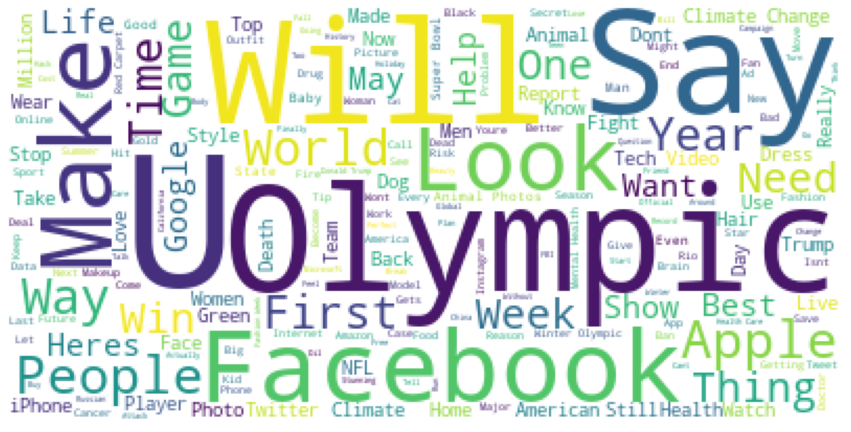

In [26]:
text = " ".join(i for i in data.clean_text1)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud)#, interpolation='bilinear')
plt.axis("off")
plt.show()